<a href="https://colab.research.google.com/github/TSffer/IA/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#####################################
# Usando Tensorflow,
# Abajo la version en Keras

import pickle
import numpy as np
import os
from urllib.request import urlretrieve
import tarfile
import zipfile
import sys


def get_data_set(name="train"):
    x = None
    y = None

    maybe_download_and_extract()

    folder_name = "cifar_10"

    f = open('./data_set/'+folder_name+'/batches.meta', 'rb')
    f.close()

    if name is "train":
        for i in range(5):
            f = open('./data_set/'+folder_name+'/data_batch_' + str(i + 1), 'rb')
            datadict = pickle.load(f, encoding='latin1')
            f.close()

            _X = datadict["data"]
            _Y = datadict['labels']

            _X = np.array(_X, dtype=float) / 255.0
            _X = _X.reshape([-1, 3, 32, 32])
            _X = _X.transpose([0, 2, 3, 1])
            _X = _X.reshape(-1, 32*32*3)

            if x is None:
                x = _X
                y = _Y
            else:
                x = np.concatenate((x, _X), axis=0)
                y = np.concatenate((y, _Y), axis=0)

    elif name is "test":
        f = open('./data_set/'+folder_name+'/test_batch', 'rb')
        datadict = pickle.load(f, encoding='latin1')
        f.close()

        x = datadict["data"]
        y = np.array(datadict['labels'])

        x = np.array(x, dtype=float) / 255.0
        x = x.reshape([-1, 3, 32, 32])
        x = x.transpose([0, 2, 3, 1])
        x = x.reshape(-1, 32*32*3)

    return x, dense_to_one_hot(y)


def dense_to_one_hot(labels_dense, num_classes=10):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1

    return labels_one_hot


def _print_download_progress(count, block_size, total_size):
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()


def maybe_download_and_extract():
    main_directory = "./data_set/"
    cifar_10_directory = main_directory+"cifar_10/"
    if not os.path.exists(main_directory):
        os.makedirs(main_directory)

        url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
        filename = url.split('/')[-1]
        file_path = os.path.join(main_directory, filename)
        zip_cifar_10 = file_path
        file_path, _ = urlretrieve(url=url, filename=file_path, reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")
        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(main_directory)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(main_directory)
        print("Done.")

        os.rename(main_directory+"./cifar-10-batches-py", cifar_10_directory)
        os.remove(zip_cifar_10)

In [0]:
import tensorflow as tf


def model():
    _IMAGE_SIZE = 32
    _IMAGE_CHANNELS = 3
    _NUM_CLASSES = 10

    with tf.name_scope('main_params'):
        x = tf.placeholder(tf.float32, shape=[None, _IMAGE_SIZE * _IMAGE_SIZE * _IMAGE_CHANNELS], name='Input')
        y = tf.placeholder(tf.float32, shape=[None, _NUM_CLASSES], name='Output')
        x_image = tf.reshape(x, [-1, _IMAGE_SIZE, _IMAGE_SIZE, _IMAGE_CHANNELS], name='images')

        global_step = tf.Variable(initial_value=0, trainable=False, name='global_step')
        learning_rate = tf.placeholder(tf.float32, shape=[], name='learning_rate')

    with tf.variable_scope('conv1') as scope:
        conv = tf.layers.conv2d(
            inputs=x_image,
            filters=32,
            kernel_size=[3, 3],
            padding='SAME',
            activation=tf.nn.relu
        )
        conv = tf.layers.conv2d(
            inputs=conv,
            filters=64,
            kernel_size=[3, 3],
            padding='SAME',
            activation=tf.nn.relu
        )
        pool = tf.layers.max_pooling2d(conv, pool_size=[2, 2], strides=2, padding='SAME')
        drop = tf.layers.dropout(pool, rate=0.25, name=scope.name)

    with tf.variable_scope('conv2') as scope:
        conv = tf.layers.conv2d(
            inputs=drop,
            filters=128,
            kernel_size=[3, 3],
            padding='SAME',
            activation=tf.nn.relu
        )
        pool = tf.layers.max_pooling2d(conv, pool_size=[2, 2], strides=2, padding='SAME')
        conv = tf.layers.conv2d(
            inputs=pool,
            filters=128,
            kernel_size=[2, 2],
            padding='SAME',
            activation=tf.nn.relu
        )
        pool = tf.layers.max_pooling2d(conv, pool_size=[2, 2], strides=2, padding='SAME')
        drop = tf.layers.dropout(pool, rate=0.25, name=scope.name)

    with tf.variable_scope('fully_connected') as scope:
        flat = tf.reshape(drop, [-1, 4 * 4 * 128])

        fc = tf.layers.dense(inputs=flat, units=1500, activation=tf.nn.relu)
        drop = tf.layers.dropout(fc, rate=0.5)
        softmax = tf.layers.dense(inputs=drop, units=_NUM_CLASSES, activation=tf.nn.softmax, name=scope.name)

    y_pred_cls = tf.argmax(softmax, axis=1)

    return x, y, softmax, y_pred_cls, global_step, learning_rate


def lr(epoch):
    learning_rate = 1e-3
    if epoch > 80:
        learning_rate *= 0.5e-3
    elif epoch > 60:
        learning_rate *= 1e-3
    elif epoch > 40:
        learning_rate *= 1e-2
    elif epoch > 20:
        learning_rate *= 1e-1
    return learning_rate


In [0]:
import numpy as np
import tensorflow as tf
from time import time
import math


#from include.data import get_data_set
#from include.model import model, lr


train_x, train_y = get_data_set("train")
test_x, test_y = get_data_set("test")
x, y, output, y_pred_cls, global_step, learning_rate = model()
global_accuracy = 0


# PARAMS
_BATCH_SIZE = 128
_EPOCH = 60
_SAVE_PATH = "./tensorboard/cifar-10-v1.0.0/"


# LOSS AND OPTIMIZER
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                   beta1=0.9,
                                   beta2=0.999,
                                   epsilon=1e-08).minimize(loss, global_step=global_step)


# PREDICTION AND ACCURACY CALCULATION
correct_prediction = tf.equal(y_pred_cls, tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# SAVER
merged = tf.summary.merge_all()
saver = tf.train.Saver()
sess = tf.Session()
train_writer = tf.summary.FileWriter(_SAVE_PATH, sess.graph)


try:
    print("\nTrying to restore last checkpoint ...")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=_SAVE_PATH)
    saver.restore(sess, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
except ValueError:
    print("\nFailed to restore checkpoint. Initializing variables instead.")
    sess.run(tf.global_variables_initializer())


def train(epoch):
    batch_size = int(math.ceil(len(train_x) / _BATCH_SIZE))
    i_global = 0

    for s in range(batch_size):
        batch_xs = train_x[s*_BATCH_SIZE: (s+1)*_BATCH_SIZE]
        batch_ys = train_y[s*_BATCH_SIZE: (s+1)*_BATCH_SIZE]

        start_time = time()
        i_global, _, batch_loss, batch_acc = sess.run(
            [global_step, optimizer, loss, accuracy],
            feed_dict={x: batch_xs, y: batch_ys, learning_rate: lr(epoch)})
        duration = time() - start_time

        if s % 10 == 0:
            percentage = int(round((s/batch_size)*100))

            bar_len = 29
            filled_len = int((bar_len*int(percentage))/100)
            bar = '=' * filled_len + '>' + '-' * (bar_len - filled_len)

            msg = "Global step: {:>5} - [{}] {:>3}% - acc: {:.4f} - loss: {:.4f} - {:.1f} sample/sec"
            print(msg.format(i_global, bar, percentage, batch_acc, batch_loss, _BATCH_SIZE / duration))

    test_and_save(i_global, epoch)


def test_and_save(_global_step, epoch):
    global global_accuracy

    i = 0
    predicted_class = np.zeros(shape=len(test_x), dtype=np.int)
    while i < len(test_x):
        j = min(i + _BATCH_SIZE, len(test_x))
        batch_xs = test_x[i:j, :]
        batch_ys = test_y[i:j, :]
        predicted_class[i:j] = sess.run(
            y_pred_cls,
            feed_dict={x: batch_xs, y: batch_ys, learning_rate: lr(epoch)}
        )
        i = j

    correct = (np.argmax(test_y, axis=1) == predicted_class)
    acc = correct.mean()*100
    correct_numbers = correct.sum()

    mes = "\nEpoch {} - accuracy: {:.2f}% ({}/{})"
    print(mes.format((epoch+1), acc, correct_numbers, len(test_x)))

    if global_accuracy != 0 and global_accuracy < acc:

        summary = tf.Summary(value=[
            tf.Summary.Value(tag="Accuracy/test", simple_value=acc),
        ])
        train_writer.add_summary(summary, _global_step)

        saver.save(sess, save_path=_SAVE_PATH, global_step=_global_step)

        mes = "This epoch receive better accuracy: {:.2f} > {:.2f}. Saving session..."
        print(mes.format(acc, global_accuracy))
        global_accuracy = acc

    elif global_accuracy == 0:
        global_accuracy = acc

    print("###########################################################################################################")


def main():
    for i in range(_EPOCH):
        print("\nEpoch: {0}/{1}\n".format((i+1), _EPOCH))
        train(i)


if __name__ == "__main__":
    main()


sess.close()


- Download progress: 100.0%
Download finished. Extracting files.
Done.


W0629 01:49:00.417875 140239015667584 deprecation.py:323] From <ipython-input-5-1ebe973dafb2>:23: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0629 01:49:00.438382 140239015667584 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0629 01:49:00.946916 140239015667584 deprecation.py:323] From <ipython-input-5-1ebe973dafb2>:32: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0629 01:49:01.230726 140239015667584 deprecation.py:323] F


Trying to restore last checkpoint ...

Failed to restore checkpoint. Initializing variables instead.

Epoch: 1/60

Global step:     1 - [>-----------------------------]   0% - acc: 0.0938 - loss: 2.3028 - 24.7 sample/sec
Global step:    11 - [>-----------------------------]   3% - acc: 0.0859 - loss: 2.2940 - 7796.0 sample/sec
Global step:    21 - [=>----------------------------]   5% - acc: 0.2188 - loss: 2.2260 - 7611.1 sample/sec
Global step:    31 - [==>---------------------------]   8% - acc: 0.2188 - loss: 2.2037 - 7993.7 sample/sec
Global step:    41 - [==>---------------------------]  10% - acc: 0.2266 - loss: 2.2069 - 7808.3 sample/sec
Global step:    51 - [===>--------------------------]  13% - acc: 0.3125 - loss: 2.1538 - 7406.2 sample/sec
Global step:    61 - [====>-------------------------]  15% - acc: 0.2734 - loss: 2.1687 - 7477.6 sample/sec
Global step:    71 - [=====>------------------------]  18% - acc: 0.2812 - loss: 2.1536 - 7548.0 sample/sec
Global step:    81 - [

W0629 01:50:14.282102 140239015667584 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.



Epoch 10 - accuracy: 74.19% (7419/10000)
This epoch receive better accuracy: 74.19 > 71.38. Saving session...
###########################################################################################################

Epoch: 11/60

Global step:  3911 - [>-----------------------------]   0% - acc: 0.8203 - loss: 1.6386 - 9105.2 sample/sec
Global step:  3921 - [>-----------------------------]   3% - acc: 0.7734 - loss: 1.6745 - 8812.7 sample/sec
Global step:  3931 - [=>----------------------------]   5% - acc: 0.8438 - loss: 1.6174 - 8617.8 sample/sec
Global step:  3941 - [==>---------------------------]   8% - acc: 0.7969 - loss: 1.6603 - 8526.2 sample/sec
Global step:  3951 - [==>---------------------------]  10% - acc: 0.7969 - loss: 1.6593 - 8379.6 sample/sec
Global step:  3961 - [===>--------------------------]  13% - acc: 0.8281 - loss: 1.6399 - 8620.1 sample/sec
Global step:  3971 - [====>-------------------------]  15% - acc: 0.7734 - loss: 1.6906 - 8433.9 sample/sec
Global ste

In [0]:
#import numpy as np
#import tensorflow as tf

##from include.data import get_data_set
##from include.model import model


test_x, test_y = get_data_set("test")
#x, y, output, y_pred_cls, global_step, learning_rate = model()
#tf.reset_default_graph()

_BATCH_SIZE = 128
_CLASS_SIZE = 10
_SAVE_PATH = "./tensorboard/cifar-10-v1.0.0/"


saver = tf.train.Saver()
sess = tf.Session()


try:
    print("\nTrying to restore last checkpoint ...")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=_SAVE_PATH)
    saver.restore(sess, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
except ValueError:
    print("\nFailed to restore checkpoint. Initializing variables instead.")
    sess.run(tf.global_variables_initializer())


def main():
    i = 0
    predicted_class = np.zeros(shape=len(test_x), dtype=np.int)
    while i < len(test_x):
        j = min(i + _BATCH_SIZE, len(test_x))
        batch_xs = test_x[i:j, :]
        batch_ys = test_y[i:j, :]
        predicted_class[i:j] = sess.run(y_pred_cls, feed_dict={x: batch_xs, y: batch_ys})
        i = j

    correct = (np.argmax(test_y, axis=1) == predicted_class)
    acc = correct.mean() * 100
    correct_numbers = correct.sum()
    print()
    print("Accuracy on Test-Set: {0:.2f}% ({1} / {2})".format(acc, correct_numbers, len(test_x)))


if __name__ == "__main__":
    main()


sess.close()

W0629 01:55:25.858767 140239015667584 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.



Trying to restore last checkpoint ...
Restored checkpoint from: ./tensorboard/cifar-10-v1.0.0/-17986

Accuracy on Test-Set: 79.15% (7915 / 10000)


In [0]:
################################
# Usando Keras

import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

In [0]:
from keras.datasets import cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

ERROR: Invalid requirement: 'keras=1.2.2'
= is not a valid operator. Did you mean == ?


In [0]:
from keras.utils import to_categorical
from keras.regularizers import l2

Training data shape :  (50000, 32, 32, 3) (50000, 1)
Testing data shape : 
Total number of outputs :  10
Output classes  :  [0 1 2 3 4 5 6 7 8 9]


Text(0.5, 1.0, 'Ground Truth : [3]')

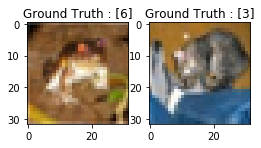

In [0]:
print('Training data shape : ', train_images.shape, train_labels.shape)
print('Testing data shape : '), test_images.shape, test_labels.shape

classes = np.unique(train_labels)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes  : ', classes)

plt.figure(figsize = [4,2])

plt.subplot(121)
plt.imshow(train_images[0,:,:],cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[0]))

plt.subplot(122)
plt.imshow(test_images[0,:,:],cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[0]))

In [0]:
nRows, nCols, nDims = train_images.shape[1:]
train_data = train_images.reshape(train_images.shape[0],nRows, nCols, nDims)
test_data = test_images.reshape(test_images.shape[0],nRows,nCols,nDims)
input_shape = (nRows, nCols, nDims)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

train_data /= 255
test_data /= 255

train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

print(nRows)
print(nCols)
print('Orginal label 0 : ', train_labels[0])
print('After convertion to categorical : ', train_labels_one_hot[0])

32
32
Orginal label 0 :  [6]
After convertion to categorical :  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [0]:
def createModel():
  model = Sequential()
  
  model.add(Conv2D(32,(3,3),padding='same', activation='relu',input_shape=input_shape))   # El paper indica 16
  model.add(Conv2D(32,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(64,(3,3),padding='same', activation='relu'))  # El paper indica el doble del anterior
  model.add(Conv2D(64,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(64,(3,3),activation='relu',W_regularizer=l2(0.01)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  model.add(Dense(256,activation='relu',W_regularizer=l2(0.01)))
  model.add(Dropout(0.5))
  model.add(Dense(nClasses,activation='softmax'))
  return model

In [0]:
model1 = createModel()
batch_size = 256
epochs = 50
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

model1.summary()

history = model1.fit(train_data,train_labels_one_hot,batch_size=batch_size, epochs = epochs,verbose=1,validation_data=(test_data, test_labels_one_hot))
model1.evaluate(test_data, test_labels_one_hot)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", kernel_regularizer=<keras.reg...)`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_regularizer=<keras.reg...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 6, 6, 64)          0         
__________

[0.6803314639568329, 0.8139]

Text(0.5, 1.0, 'Loss Curves')

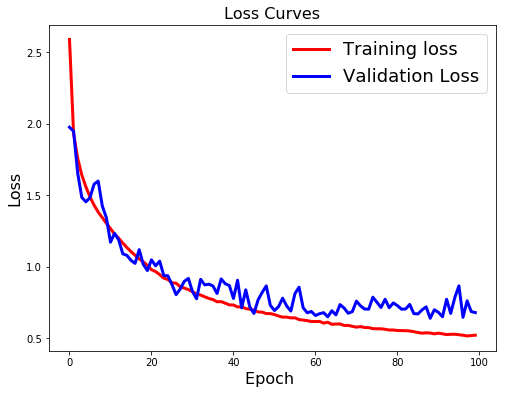

In [0]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth = 3.0)
plt.plot(history.history['val_loss'],'b',linewidth= 3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epoch ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

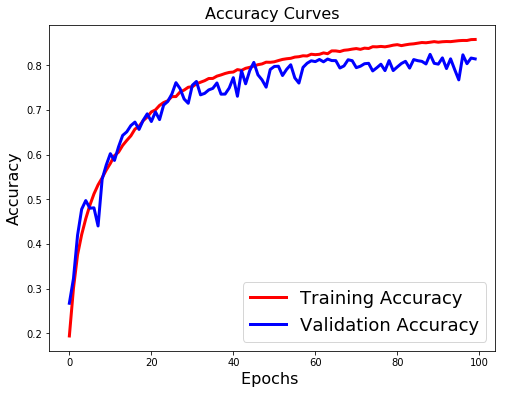

In [0]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy','Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

model2 = createModel()

model2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
batch_size = 256
epoch = 50
datagen  = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,vertical_flip=False)

history2 = model2.fit_generator(datagen.flow(train_data, train_labels_one_hot,batch_size=batch_size),
                               steps_per_epoch=int(np.ceil(train_data.shape[0]/float(batch_size))),
                               epochs=epochs,
                               validation_data=(test_data,test_labels_one_hot),
                               workers=4)

model2.evaluate(test_data, test_labels_one_hot)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", kernel_regularizer=<keras.reg...)`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_regularizer=<keras.reg...)`


Epoch 1/100
196/196 [==============================] - 24s 124ms/step - loss: 2.5686 - acc: 0.2104 - val_loss: 2.0556 - val_acc: 0.2467
Epoch 2/100
196/196 [==============================] - 22s 113ms/step - loss: 1.9603 - acc: 0.3006 - val_loss: 1.7854 - val_acc: 0.3721
Epoch 3/100
196/196 [==============================] - 23s 115ms/step - loss: 1.8241 - acc: 0.3553 - val_loss: 1.6600 - val_acc: 0.4283
Epoch 4/100
196/196 [==============================] - 22s 115ms/step - loss: 1.7294 - acc: 0.3892 - val_loss: 1.5327 - val_acc: 0.4505
Epoch 5/100
196/196 [==============================] - 22s 113ms/step - loss: 1.6589 - acc: 0.4145 - val_loss: 1.4939 - val_acc: 0.4770
Epoch 6/100
196/196 [==============================] - 22s 113ms/step - loss: 1.5943 - acc: 0.4412 - val_loss: 1.5299 - val_acc: 0.4697
Epoch 7/100
196/196 [==============================] - 22s 111ms/step - loss: 1.5410 - acc: 0.4694 - val_loss: 1.4882 - val_acc: 0.4898
Epoch 8/100
196/196 [===========================

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Loss Curves')

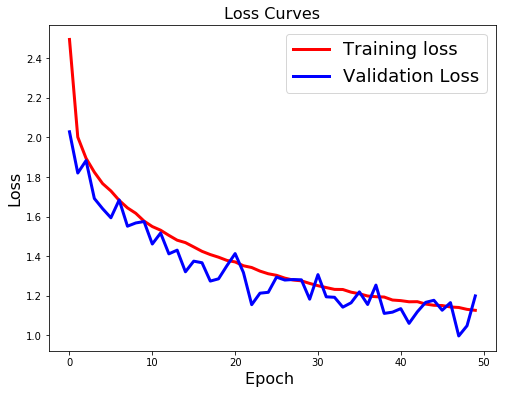

In [0]:
plt.figure(figsize=[8,6])
plt.plot(history2.history['loss'],'r',linewidth = 3.0)
plt.plot(history2.history['val_loss'],'b',linewidth= 3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epoch ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

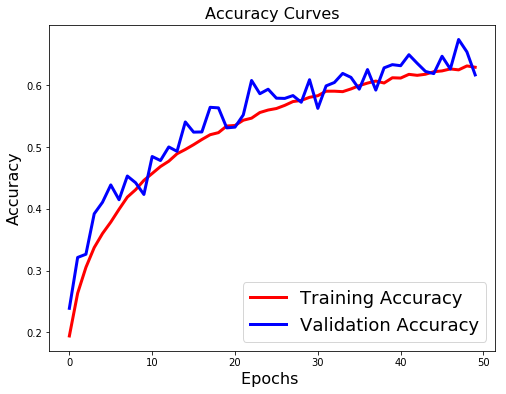

In [0]:
plt.figure(figsize=[8,6])
plt.plot(history2.history['acc'],'r',linewidth=3.0)
plt.plot(history2.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy','Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)